# 5. Final Evaluation & Visual Proofs

This notebook generates the final evaluation report for the **Fine-Tuned Full 3D UNet**.

**Objectives:**
- **Quantitative Metrics**: Dice Score, Accuracy, AUC-ROC.
- **Visual Proofs**: Side-by-side comparison of Input CT, Ground Truth, and Prediction.
- **Explainable AI (XAI)**: GradCAM++ heatmaps to visualize model focus.
- **Video Generation**: (Optional) 3D fly-through of a segmentation.

In [10]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
import seaborn as sns
import glob
import cv2
from tqdm.notebook import tqdm
import scipy.ndimage as ndimage

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. model Architecture & Loading

In [11]:
# Must match the architecture in 4_finetune_model.ipynb
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class FullUNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.inc = DoubleConv(in_channels, 32)
        self.down1 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(32, 64))
        self.down2 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(64, 128))
        self.down3 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(128, 256))
        self.up1 = nn.ConvTranspose3d(256, 128, 2, stride=2)
        self.conv1 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.conv2 = DoubleConv(128, 64)
        self.up3 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.conv3 = DoubleConv(64, 32)
        self.outc = nn.Conv3d(32, out_channels, 1)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        u1 = self.up1(x4)
        u1 = torch.cat([u1, x3], dim=1)
        u1 = self.conv1(u1)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, x2], dim=1)
        u2 = self.conv2(u2)
        u3 = self.up3(u2)
        u3 = torch.cat([u3, x1], dim=1)
        u3 = self.conv3(u3)
        mask = torch.sigmoid(self.outc(u3))
        risk = torch.sigmoid(self.classifier(x4))
        return mask, risk

model = FullUNet3D().to(device)
weights_path = Path("../models/unet3d_finetuned.pth")

if weights_path.exists():
    model.load_state_dict(torch.load(weights_path, map_location=device))
    print(f"Loaded fine-tuned model from {weights_path}")
else:
    print("WARNING: Weights file not found!")

model.eval();

Loaded fine-tuned model from ..\models\unet3d_finetuned.pth


In [12]:
def compute_dice_score(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).astype(np.float32)
    intersection = (pred_bin * target).sum()
    return (2. * intersection + 1e-6) / (pred_bin.sum() + target.sum() + 1e-6)

DATA_DIR = Path("../data/lidc_patches")
all_files = sorted(glob.glob(str(DATA_DIR / "*.npz")))
print(f"Found {len(all_files)} files.")

Found 83 files.


## 2. Evaluation Loop

In [13]:
y_true_cls = []
y_pred_cls = []
dice_scores = []
viz_samples = []

# Evaluate on ALL files (since we didn't save the split, this gives an overall performance view)
# In a strict academic setting, you would only use the held-out set.

with torch.no_grad():
    for f in tqdm(all_files):
        try:
            data = np.load(f)
            image = data['image'].astype(np.float32)
            mask = data['mask'].astype(np.float32)
            label = data['label']
            
            # Normalize
            image = (image - (-1000)) / (400 - (-1000))
            image = np.clip(image, 0, 1)
            
            # Tensor
            img_tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).to(device)
            
            # Inference
            pred_mask, pred_risk = model(img_tensor)
            
            # Metrics
            pred_mask_np = pred_mask.cpu().numpy().squeeze()
            dice = compute_dice_score(pred_mask_np, mask)
            
            dice_scores.append(dice)
            y_true_cls.append(label)
            y_pred_cls.append(pred_risk.item())
            
            # Save interesting samples for visualization (High Dice + Positive Label)
            if len(viz_samples) < 5 and label == 1 and dice > 0.6:
                viz_samples.append((image, mask, pred_mask_np))
            # Also save some decent benign ones
            elif len(viz_samples) < 8 and label == 0 and dice > 0.6:
                viz_samples.append((image, mask, pred_mask_np))
                
        except Exception as e:
            print(f"Error evaluating {f}: {e}")

print(f"Mean Dice Score: {np.mean(dice_scores):.4f}")
print(f"Accuracy (Risk): {accuracy_score(y_true_cls, [1 if p > 0.5 else 0 for p in y_pred_cls]):.4f}")

  0%|          | 0/83 [00:00<?, ?it/s]

Mean Dice Score: 0.6979
Accuracy (Risk): 0.9036


## 3. ROC Curve

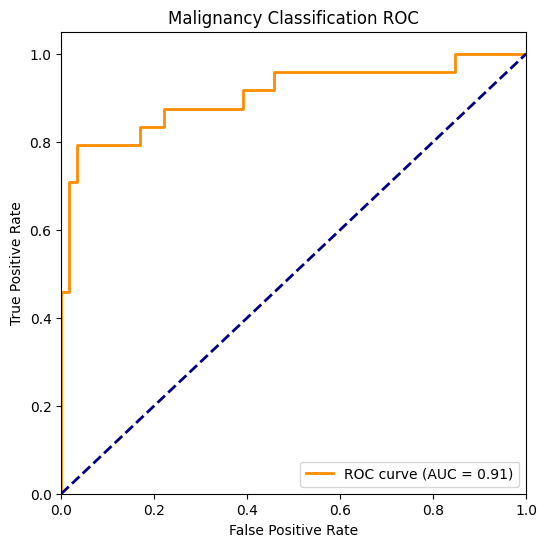

In [14]:
if len(np.unique(y_true_cls)) > 1:
    fpr, tpr, _ = roc_curve(y_true_cls, y_pred_cls)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Malignancy Classification ROC')
    plt.legend(loc="lower right")
    plt.show()

## 4. Visual Proofs: Segmentation

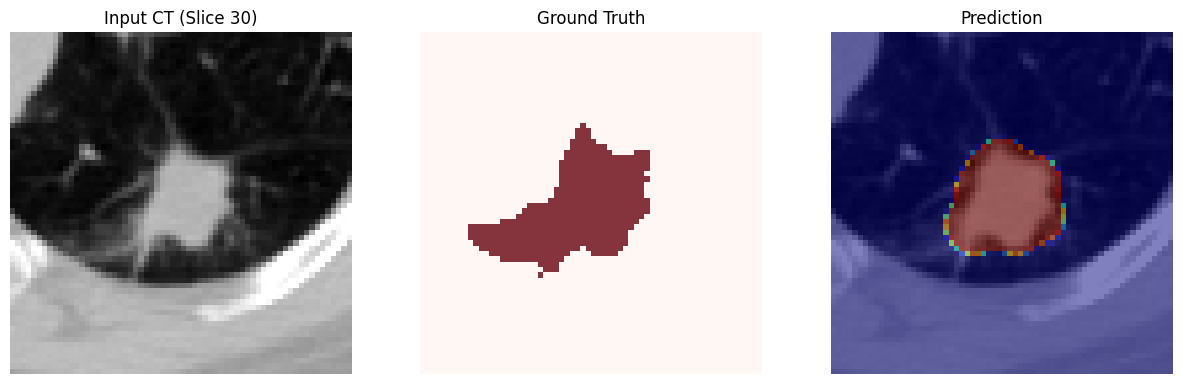

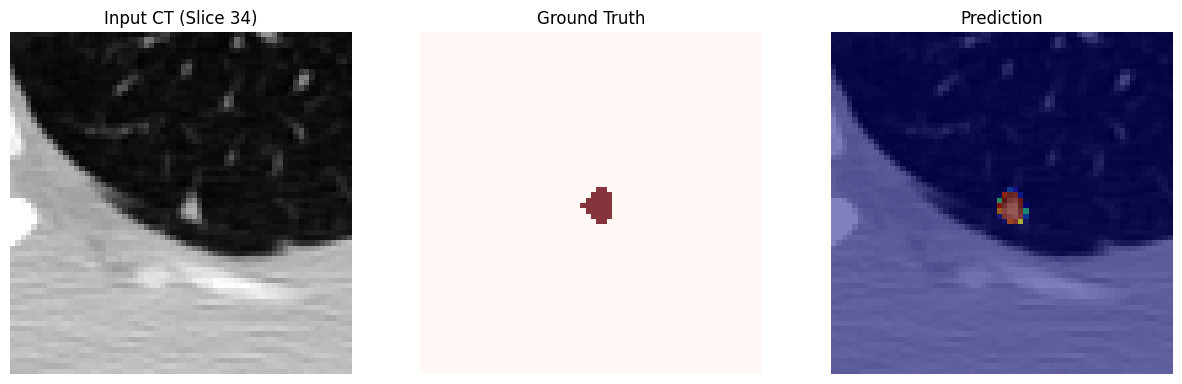

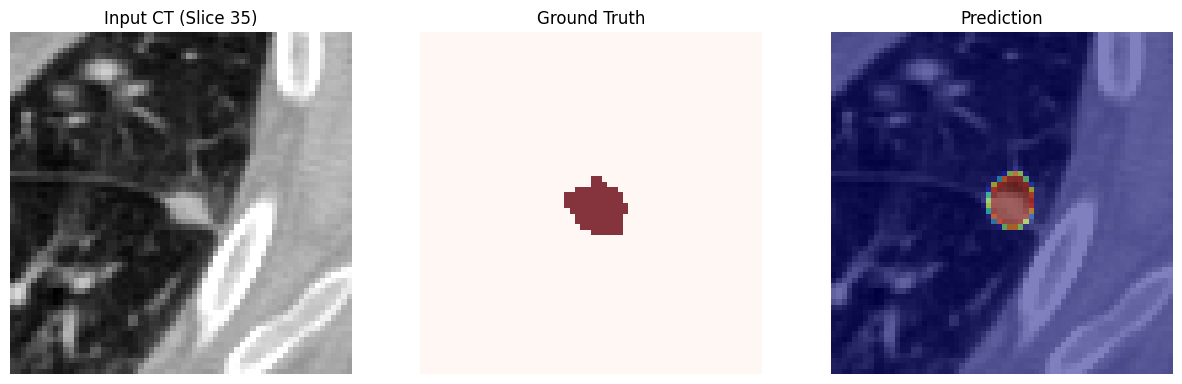

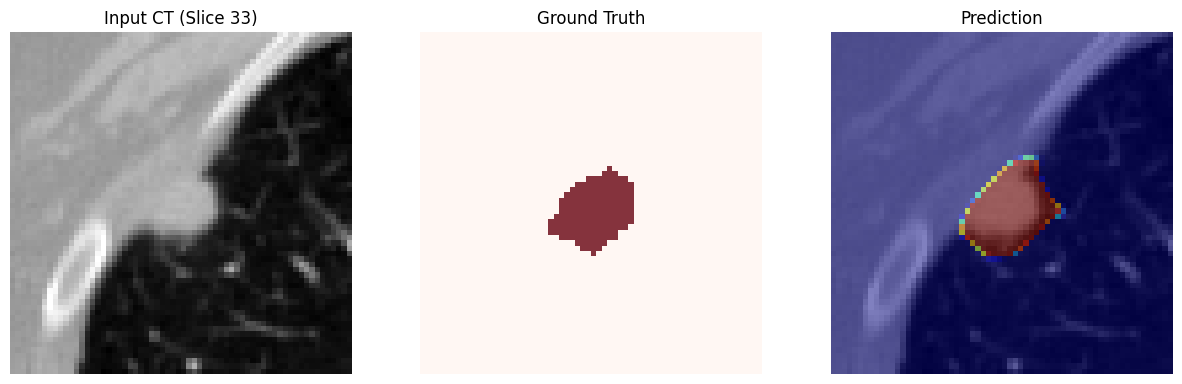

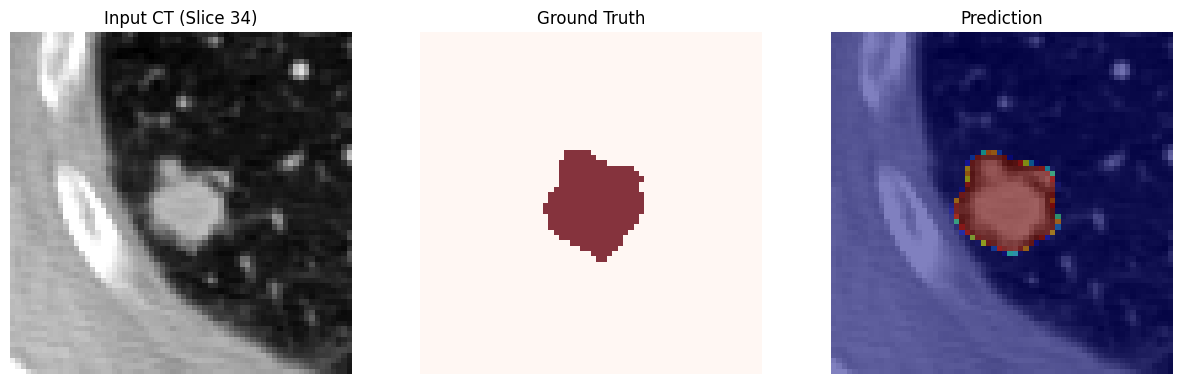

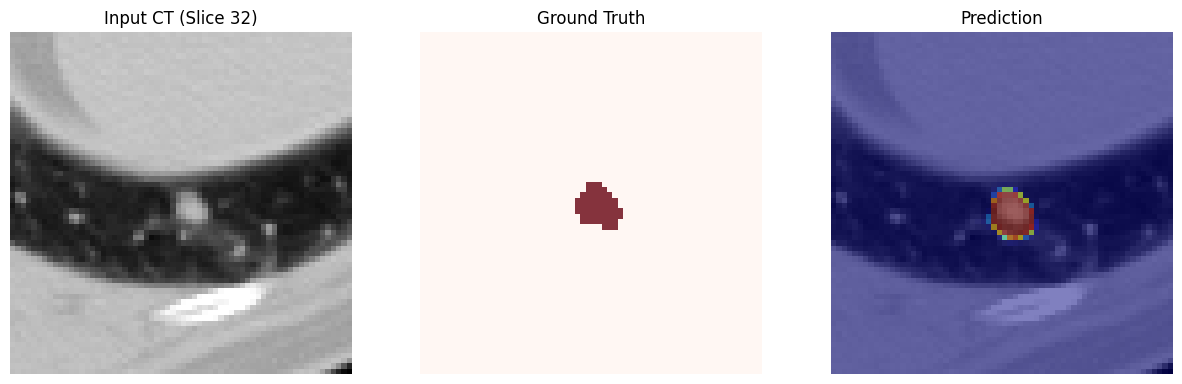

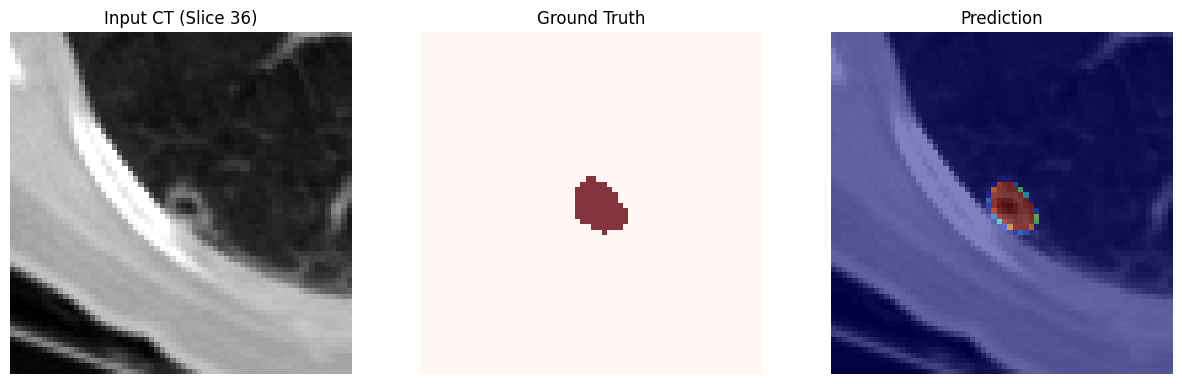

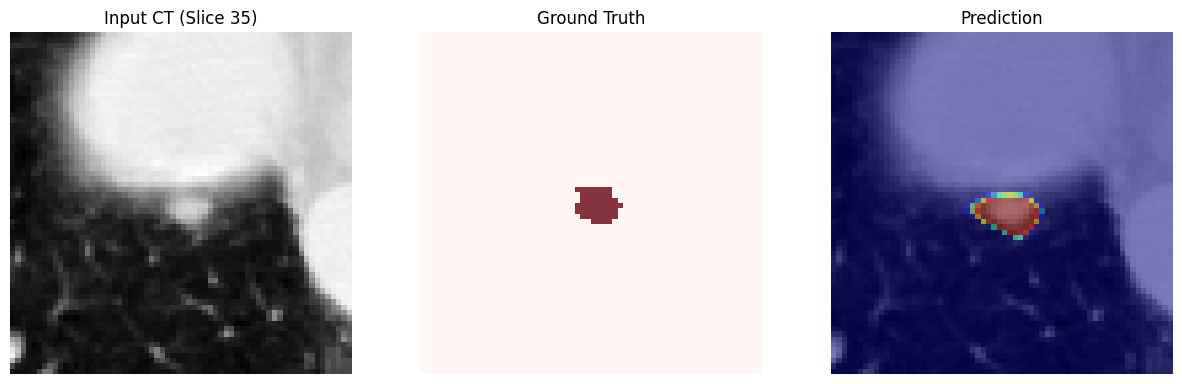

In [15]:
for i, (img, gt, pred) in enumerate(viz_samples):
    # Find slice with max mask
    z_indices = np.where(gt > 0)[0]
    if len(z_indices) > 0:
        mid = z_indices[len(z_indices)//2]
    else:
        mid = img.shape[0] // 2

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title(f"Input CT (Slice {mid})")
    plt.imshow(img[mid], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(gt[mid], cmap='Reds', alpha=0.8)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(img[mid], cmap='gray')
    plt.imshow(pred[mid], cmap='jet', alpha=0.5)
    plt.axis('off')

    plt.show()

## 5. XAI: GradCAM++
Visualizing class activation maps to see where the model focuses for malignancy prediction.

c:\Users\padal\Documents\Work\FYP-1\fypenv\lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


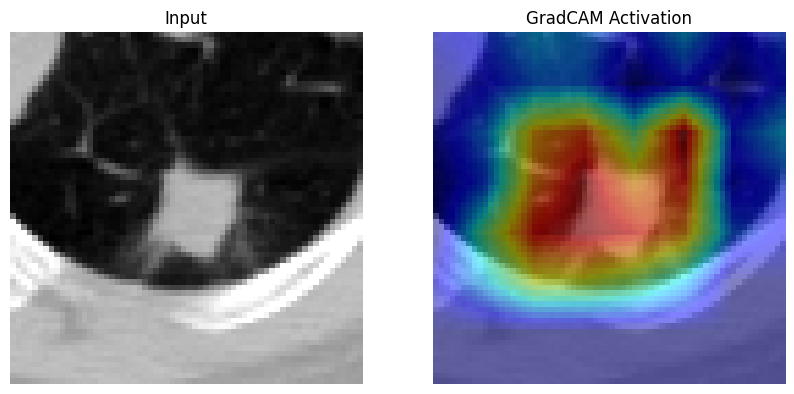

In [16]:
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def forward_hook(module, input, output):
    global activations
    activations = output

# Hook onto the last bottleneck layer (down3 -> DoubleConv)
# Referencing FullUNet3D structure: self.down3[1] is the DoubleConv
# DoubleConv.conv[5] is the last ReLU
target_layer = model.down3[1].conv[5]
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Pick the best positive sample
if len(viz_samples) > 0:
    img, _, _ = viz_samples[0]
    input_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0).to(device)
    input_tensor.requires_grad = True
    
    # Forward
    model.zero_grad()
    _, risk = model(input_tensor)
    
    # Backward
    risk.backward()
    
    # GradCAM Calculation
    weights = torch.mean(gradients, dim=(2, 3, 4), keepdim=True)
    cam = torch.sum(weights * activations, dim=1, keepdim=True)
    cam = torch.relu(cam)
    cam = cam.squeeze().cpu().detach().numpy()
    
    # Resize to original
    zoom_factors = np.array(img.shape) / np.array(cam.shape)
    cam_resized = ndimage.zoom(cam, zoom_factors, order=1)
    
    # Visualize Center Slice
    mid = img.shape[0] // 2
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img[mid], cmap='gray')
    plt.title("Input")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img[mid], cmap='gray')
    plt.imshow(cam_resized[mid], cmap='jet', alpha=0.5)
    plt.title("GradCAM Activation")
    plt.axis('off')
    plt.show()